In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch

def visualize_dataset_sample(dataset, idx, figsize=(15, 10)):
    """
    Visualize a sample from the dataset showing:
    - Original image with point prompts
    - Ground truth masks overlaid
    - Individual masks in a grid
    """
    sample = dataset[idx]
    
    # Extract data
    image = sample['image']  # [3, H, W]
    gt_masks = sample['gt_masks']  # [Num_Chars, 256, 256]
    gt_points = sample['gt_points']  # [Num_Chars, 2]
    
    # Convert image tensor to numpy for visualization
    if isinstance(image, torch.Tensor):
        # Denormalize the image
        pixel_mean = dataset.sam_model.pixel_mean.cpu().numpy()
        pixel_std = dataset.sam_model.pixel_std.cpu().numpy()
        
        image_np = image.cpu().numpy()
        image_np = image_np * pixel_std[:, None, None] + pixel_mean[:, None, None]
        image_np = np.transpose(image_np, (1, 2, 0))  # [H, W, 3]
        image_np = np.clip(image_np / 255.0, 0, 1)  # Normalize to [0, 1]
    
    num_chars = gt_masks.shape[0]
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    
    # 1. Original image with points
    axes[0, 0].imshow(image_np)
    axes[0, 0].set_title(f'Image with Point Prompts ({num_chars} chars)')
    
    # Plot points
    if isinstance(gt_points, torch.Tensor):
        points_np = gt_points.cpu().numpy()
    else:
        points_np = gt_points
        
    for i, point in enumerate(points_np):
        axes[0, 0].plot(point[0], point[1], 'ro', markersize=8, label=f'Char {i+1}')
        axes[0, 0].annotate(f'{i+1}', (point[0], point[1]), xytext=(5, 5), 
                           textcoords='offset points', color='white', fontweight='bold')
    axes[0, 0].set_axis_off()
    
    # 2. Image with all masks overlaid
    axes[0, 1].imshow(image_np)
    
    # Create a combined mask overlay
    combined_mask = np.zeros(gt_masks.shape[1:])
    colors = plt.cm.Set3(np.linspace(0, 1, num_chars))
    
    for i, mask in enumerate(gt_masks):
        if isinstance(mask, torch.Tensor):
            mask_np = mask.cpu().numpy()
        else:
            mask_np = mask
            
        # Resize mask to match image size
        mask_resized = np.array(Image.fromarray(mask_np).resize((image_np.shape[1], image_np.shape[0])))
        mask_binary = mask_resized > 0.5
        
        # Create colored overlay
        overlay = np.zeros((*mask_binary.shape, 4))
        overlay[mask_binary] = [*colors[i][:3], 0.6]  # Semi-transparent
        axes[0, 1].imshow(overlay)
    
    axes[0, 1].set_title('Image with GT Masks Overlay')
    axes[0, 1].set_axis_off()
    
    # 3. Combined masks only
    axes[0, 2].imshow(combined_mask, cmap='gray')
    axes[0, 2].set_title('Combined GT Masks')
    axes[0, 2].set_axis_off()
    
    # 4-6. Individual masks (show first 3)
    for i in range(min(3, num_chars)):
        row = 1
        col = i
        
        if isinstance(gt_masks[i], torch.Tensor):
            mask_np = gt_masks[i].cpu().numpy()
        else:
            mask_np = gt_masks[i]
            
        axes[row, col].imshow(mask_np, cmap='gray')
        axes[row, col].set_title(f'Mask {i+1}')
        axes[row, col].set_axis_off()
    
    # Hide unused subplots
    for i in range(num_chars, 3):
        axes[1, i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Print some info
    print(f"Sample {idx} Info:")
    print(f"Image shape: {image.shape}")
    print(f"GT masks shape: {gt_masks.shape}")
    print(f"GT points shape: {gt_points.shape}")
    print(f"Number of characters: {num_chars}")
    print(f"Point coordinates: {points_np}")

def visualize_multiple_samples(dataset, indices=[0, 1, 2], figsize=(20, 15)):
    """Visualize multiple samples side by side"""
    num_samples = len(indices)
    fig, axes = plt.subplots(num_samples, 3, figsize=figsize)
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for row, idx in enumerate(indices):
        sample = dataset[idx]
        image = sample['image']
        gt_masks = sample['gt_masks']
        gt_points = sample['gt_points']
        
        # Denormalize image
        pixel_mean = dataset.sam_model.pixel_mean.cpu().numpy()
        pixel_std = dataset.sam_model.pixel_std.cpu().numpy()
        
        image_np = image.cpu().numpy()
        image_np = image_np * pixel_std[:, None, None] + pixel_mean[:, None, None]
        image_np = np.transpose(image_np, (1, 2, 0))
        image_np = np.clip(image_np / 255.0, 0, 1)
        
        # Column 1: Image with points
        axes[row, 0].imshow(image_np)
        points_np = gt_points.cpu().numpy()
        for i, point in enumerate(points_np):
            axes[row, 0].plot(point[0], point[1], 'ro', markersize=6)
        axes[row, 0].set_title(f'Sample {idx} - Image + Points')
        axes[row, 0].set_axis_off()
        
        # Column 2: First mask
        if len(gt_masks) > 0:
            axes[row, 1].imshow(gt_masks[0].cpu().numpy(), cmap='gray')
            axes[row, 1].set_title(f'Sample {idx} - First Mask')
        axes[row, 1].set_axis_off()
        
        # Column 3: Combined masks
        combined = torch.sum(gt_masks, dim=0).cpu().numpy()
        axes[row, 2].imshow(combined, cmap='hot')
        axes[row, 2].set_title(f'Sample {idx} - Combined Masks')
        axes[row, 2].set_axis_off()
    
    plt.tight_layout()
    plt.show()

# Usage example:
# dataset = GuidedPromptDataset('path/to/index.json', sam_model)
# visualize_dataset_sample(dataset, 0)
# visualize_multiple_samples(dataset, [0, 1, 2])

In [3]:
import torch
import argparse
from tqdm import tqdm
from segment_anything import sam_model_registry

from data_loader import GuidedPromptDataset
from utils import CombinedLoss


device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Setup Model
sam = sam_model_registry['vit_b']('./checkpoints/sam_vit_b_01ec64.pth')
sam.to(device)

# # 3. Setup Dataloader
dataset = GuidedPromptDataset(index_file='master_index.json', sam_model=sam)


Dataset length: 10
Debug - Image shape: torch.Size([3, 1024, 1024])
Debug - GT masks shape: torch.Size([372, 256, 256])
Debug - GT points shape: torch.Size([372, 2])


/tmp/ipykernel_1542693/1236784438.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  alpha=0.6, cmap=plt.cm.get_cmap('Set1', num_chars))


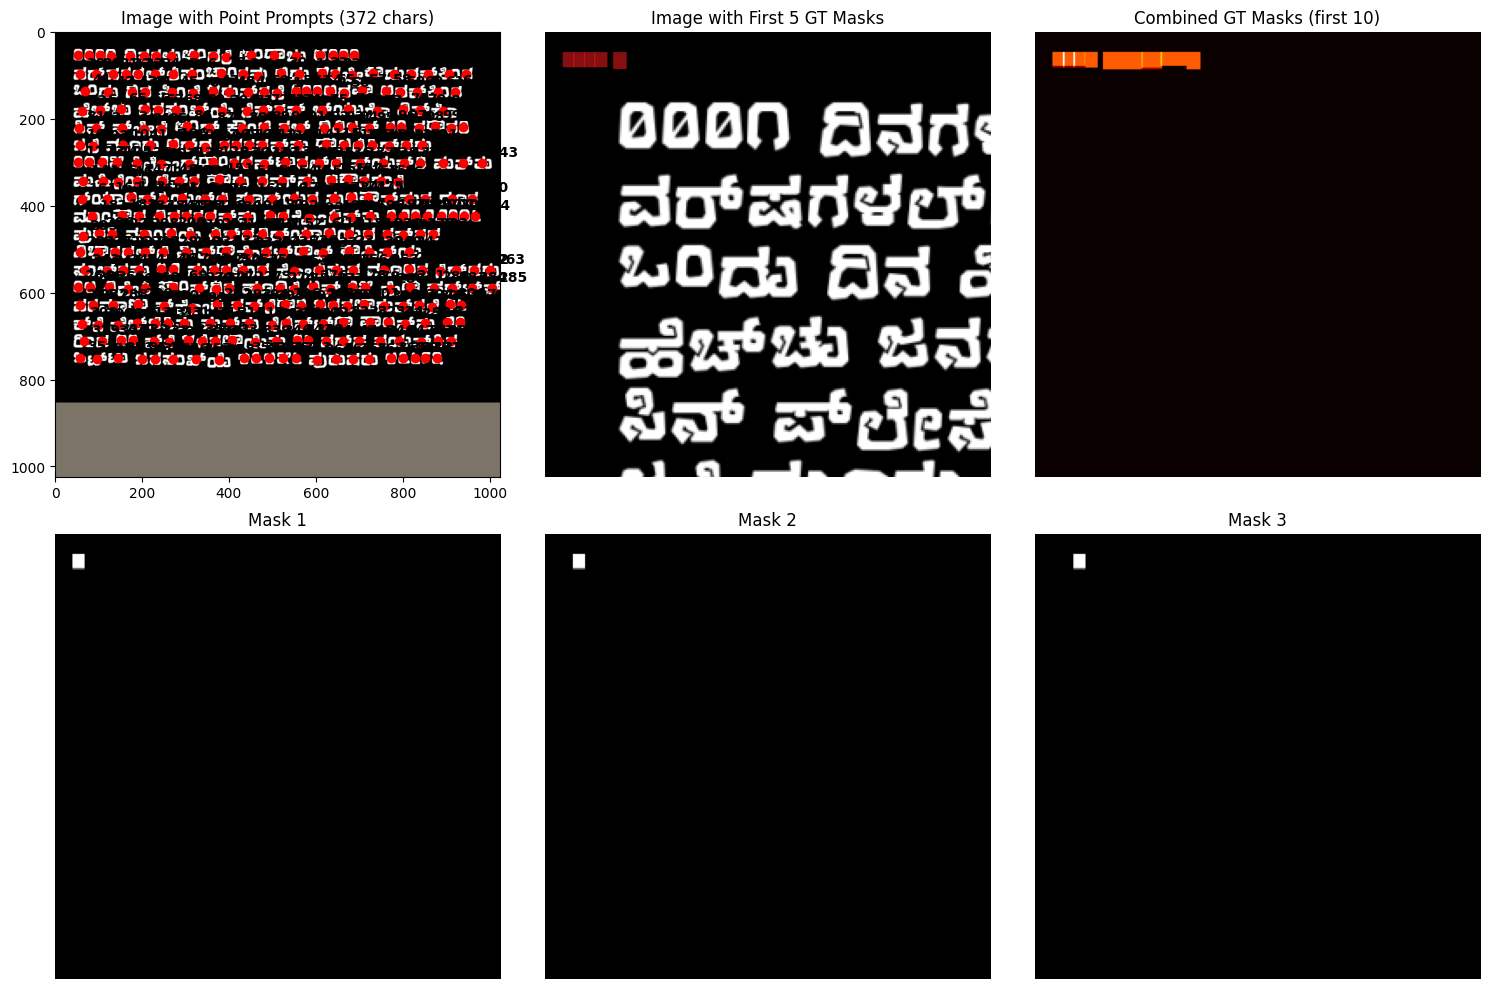

Sample 0 - Number of characters: 372


In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image

def visualize_dataset_sample(dataset, idx, figsize=(15, 10)):
    """
    Visualize a sample from the dataset showing:
    - Original image with point prompts
    - Ground truth masks overlaid
    - Individual masks in a grid
    """
    sample = dataset[idx]
    
    # Extract data
    image = sample['image']  # [3, H, W]
    gt_masks = sample['gt_masks']  # [Num_Chars, 256, 256]
    gt_points = sample['gt_points']  # [Num_Chars, 2]
    
    # Debug: Print shapes first
    print(f"Debug - Image shape: {image.shape}")
    print(f"Debug - GT masks shape: {gt_masks.shape}")
    print(f"Debug - GT points shape: {gt_points.shape}")
    
    # Convert image tensor to numpy for visualization
    if isinstance(image, torch.Tensor):
        # Denormalize the image safely
        image_np = image.cpu().numpy()
        pixel_mean = dataset.sam_model.pixel_mean.cpu().numpy()
        pixel_std = dataset.sam_model.pixel_std.cpu().numpy()
        
        # Fix: Reshape pixel_mean and pixel_std to ensure broadcasting works
        if len(pixel_mean.shape) == 3:  # If they're already [3, 1, 1]
            pixel_mean = pixel_mean.reshape(3, 1, 1)
            pixel_std = pixel_std.reshape(3, 1, 1)
        else:  # If they're just [3]
            pixel_mean = pixel_mean.reshape(3, 1, 1)
            pixel_std = pixel_std.reshape(3, 1, 1)
            
        # Denormalize
        image_np = image_np * pixel_std + pixel_mean
        
        # Fix: Use moveaxis instead of transpose for more reliable dimension swapping
        image_np = np.moveaxis(image_np, 0, 2)  # [C, H, W] -> [H, W, C]
        
        # Normalize to [0, 1] for display
        image_np = np.clip(image_np / 255.0, 0, 1)
    
    num_chars = gt_masks.shape[0]
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    
    # 1. Original image with points
    axes[0, 0].imshow(image_np)
    axes[0, 0].set_title(f'Image with Point Prompts ({num_chars} chars)')
    
    # Plot points
    if isinstance(gt_points, torch.Tensor):
        points_np = gt_points.cpu().numpy()
    else:
        points_np = gt_points
        
    for i, point in enumerate(points_np):
        axes[0, 0].plot(point[0], point[1], 'ro', markersize=6)
        # Use black color for better visibility on the image
        axes[0, 0].annotate(f'{i+1}', (point[0], point[1]), xytext=(5, 5), 
                           textcoords='offset points', color='black', fontweight='bold')
    
    # 2. Image with first 5 masks overlaid (avoid overlaying hundreds)
    axes[0, 1].imshow(image_np)
    
    # Create colored mask overlays - limit to first 5 for clarity
    colors = plt.cm.tab10(np.linspace(0, 1, min(5, num_chars)))
    
    for i in range(min(5, num_chars)):
        mask = gt_masks[i]
        if isinstance(mask, torch.Tensor):
            mask_np = mask.cpu().numpy()
        else:
            mask_np = mask
            
        # Create colored overlay
        mask_binary = mask_np > 0.5
        # Just display the mask at its original resolution
        axes[0, 1].imshow(np.ma.masked_where(~mask_binary, mask_binary), 
                         alpha=0.6, cmap=plt.cm.get_cmap('Set1', num_chars))
    
    axes[0, 1].set_title('Image with First 5 GT Masks')
    axes[0, 1].set_axis_off()
    
    # 3. Combined masks only - show first 10 to avoid overcluttering
    combined_mask = torch.sum(gt_masks[:10], dim=0).cpu().numpy()
    axes[0, 2].imshow(combined_mask, cmap='hot')
    axes[0, 2].set_title('Combined GT Masks (first 10)')
    axes[0, 2].set_axis_off()
    
    # 4-6. Individual masks (show first 3)
    for i in range(min(3, num_chars)):
        mask_np = gt_masks[i].cpu().numpy()
        axes[1, i].imshow(mask_np, cmap='gray')
        axes[1, i].set_title(f'Mask {i+1}')
        axes[1, i].set_axis_off()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Sample {idx} - Number of characters: {num_chars}")

# Visualize the first sample
print(f"Dataset length: {len(dataset)}")
visualize_dataset_sample(dataset, 0)

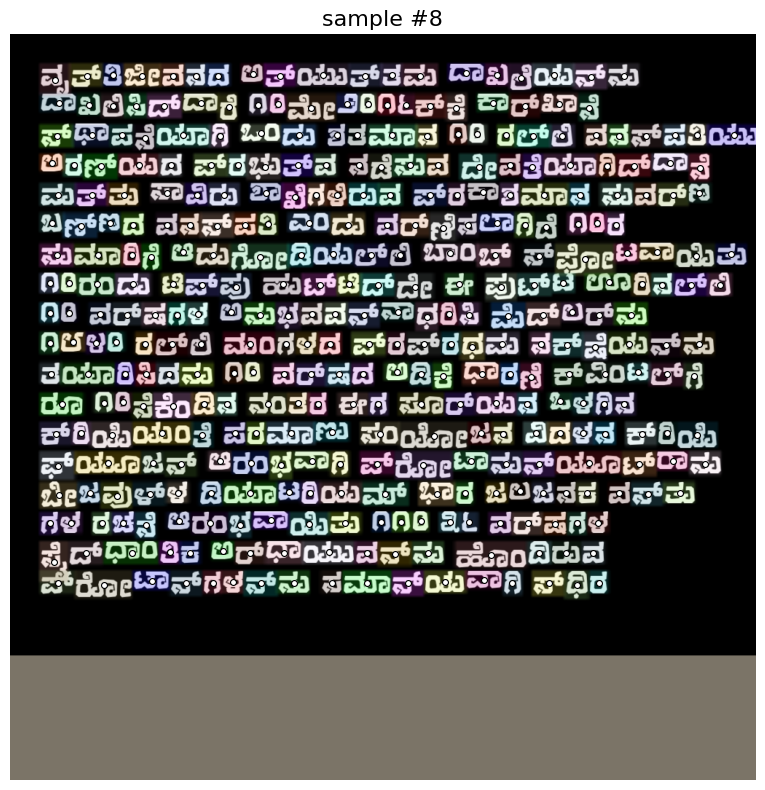

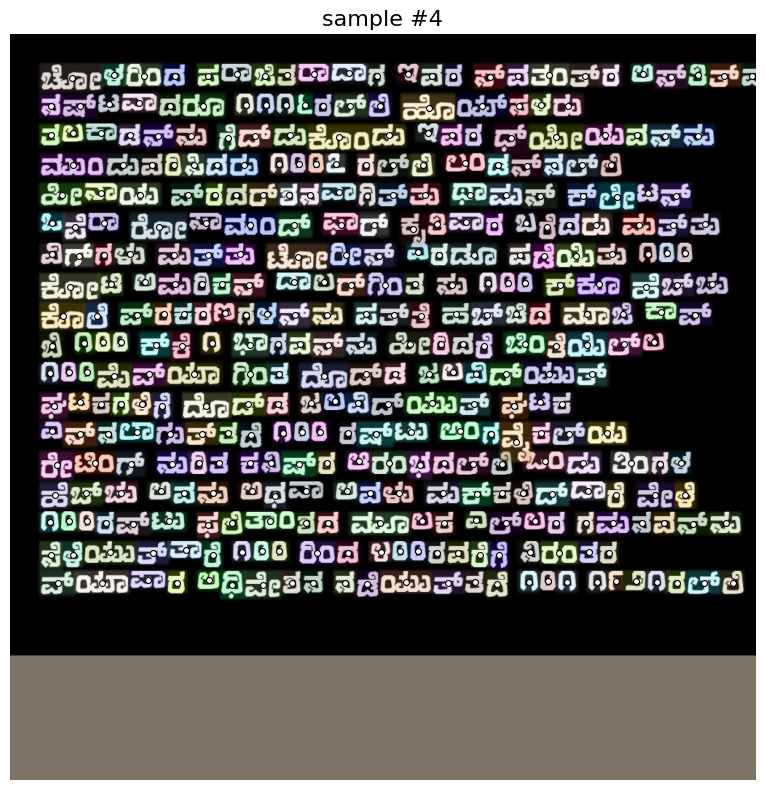

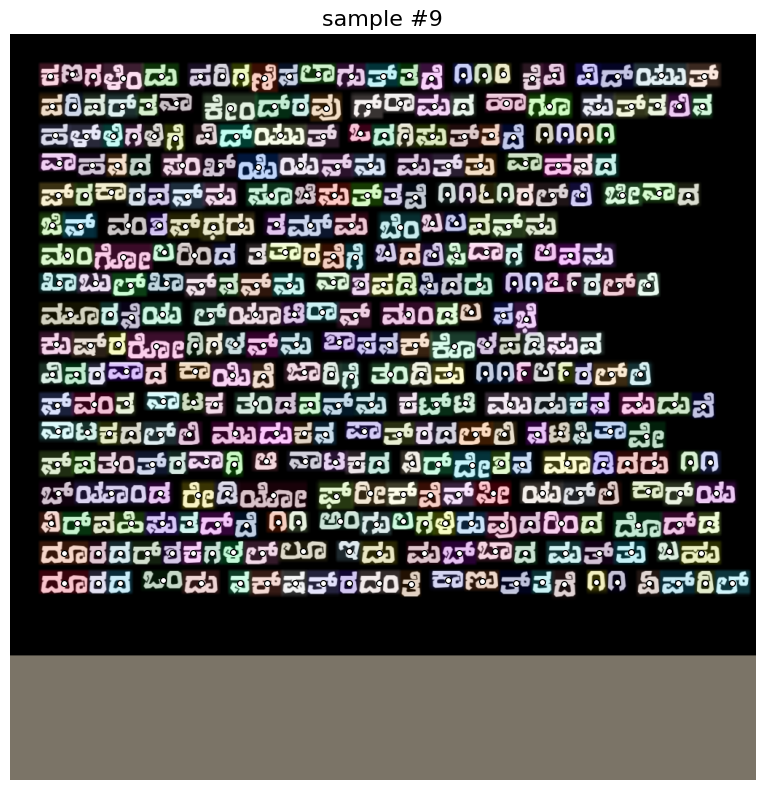

In [3]:
# visualize_dataset.py
import math
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

def _sam_device(sam_model):
    # SAM models don't expose `.device` directly; infer it from parameters.
    return next(sam_model.parameters()).device

def denorm_to_uint8(img_chw, sam_model):
    """
    img_chw: (3, H, W) tensor that was normalized with sam_model.pixel_mean/std
    returns: (H, W, 3) uint8 numpy for display
    """
    device = img_chw.device
    mean = sam_model.pixel_mean.to(device)        # (3,1,1)
    std  = sam_model.pixel_std.to(device)         # (3,1,1)
    x = (img_chw * std) + mean
    x = x.clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
    return x

def tile_masks(masks_nhw, max_cols=6):
    """
    masks_nhw: (N, 256, 256) tensor/np with values ~0..255 or 0..1
    returns: grid (H, W) float32 in [0,1], rows, cols
    """
    m = masks_nhw.detach().cpu().float().numpy()
    # Normalize to [0,1] for display
    if m.max() > 1.0:
        m = m / 255.0
    n = m.shape[0]
    if n == 0:
        return np.zeros((256, 256), dtype=np.float32), 1, 1
    cols = min(max_cols, n)
    rows = math.ceil(n / cols)
    grid = np.zeros((rows * 256, cols * 256), dtype=np.float32)
    for i in range(n):
        r, c = divmod(i, cols)
        grid[r*256:(r+1)*256, c*256:(c+1)*256] = m[i]
    return grid, rows, cols

# def show_sample(sample, sam_model, title=None):
#     """
#     sample: dict returned by your dataset.__getitem__
#       - image: (3,H,W) normalized & padded
#       - gt_points: (N,2) xy in transformed coords (before padding; padding added on right/bottom only, so OK)
#       - gt_masks: (N,256,256)
#     """
#     img = denorm_to_uint8(sample['image'], sam_model)
#     pts = sample['gt_points'].detach().cpu().numpy() if len(sample['gt_points']) else np.zeros((0,2))
#     masks = sample['gt_masks']  # (N,256,256)
    
#     # Get number of masks
#     num_masks = len(masks)
    
#     # Calculate layout - image + individual masks
#     total_plots = 1 + num_masks
#     cols = min(4, total_plots)  # Max 4 columns
#     rows = math.ceil(total_plots / cols)
    
#     # Create figure with subplots
#     fig = plt.figure(figsize=(cols*3, rows*3))
    
#     # Plot the image with points
#     ax0 = fig.add_subplot(rows, cols, 1)
#     ax0.imshow(img)
#     if len(pts):
#         ax0.scatter(pts[:,0], pts[:,1], s=18, linewidths=0.6, edgecolors='k')
#     ax0.set_title('Image with point prompts')
#     ax0.axis('off')
    
#     # Plot individual masks
#     for i in range(10):
#         ax = fig.add_subplot(rows, cols, i + 2)  # +2 because image is at position 1
#         mask = masks[i].detach().cpu().numpy()
        
#         # Normalize mask if needed
#         if mask.max() > 1.0:
#             mask = mask / 255.0
            
#         ax.imshow(mask, cmap='gray', vmin=0, vmax=1)
#         ax.set_title(f'Mask #{i}')
#         ax.axis('off')
    
#     if title:
#         fig.suptitle(title, fontsize=16)
    
#     plt.tight_layout()
#     plt.show()
    
def show_sample(sample, sam_model, title=None):
    """
    sample: dict returned by your dataset.__getitem__
      - image: (3,H,W) normalized & padded
      - gt_points: (N,2) xy in transformed coords (before padding; padding added on right/bottom only, so OK)
      - gt_masks: (N,256,256)
    """
    img = denorm_to_uint8(sample['image'], sam_model)
    pts = sample['gt_points'].detach().cpu().numpy() if len(sample['gt_points']) else np.zeros((0,2))
    masks = sample['gt_masks']  # (N,256,256)
    num_masks = len(masks)
    
    # Create figure
    plt.figure(figsize=(10, 8))
    
    # Display original image
    plt.imshow(img)
    
    # Overlay each mask with different color at 25% opacity
    for i in range(num_masks):
        mask = masks[i].detach().cpu().numpy()
        # Normalize mask if needed
        if mask.max() > 1.0:
            mask = mask / 255.0
            
        # resize mask to match image size
        mask = F.interpolate(torch.tensor(mask).unsqueeze(0).unsqueeze(0),
                             size=(img.shape[0], img.shape[1]),
                             mode='bilinear', align_corners=False).squeeze().numpy()
        
        # Generate random color
        random_color = np.random.rand(3)
        
        # Create colored mask overlay
        colored_mask = np.zeros((img.shape[0], img.shape[1], 4))
        colored_mask[:,:,0] = random_color[0]  # R
        colored_mask[:,:,1] = random_color[1]  # G
        colored_mask[:,:,2] = random_color[2]  # B
        colored_mask[:,:,3] = mask * 0.25   # Alpha at 25%
        
        plt.imshow(colored_mask)
        
    
    # Add points
    if len(pts):
        plt.scatter(pts[:,0], pts[:,1], s=18, color='white', linewidths=0.8, edgecolors='black')
    
    if title:
        plt.title(title, fontsize=16)
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# -------------------- Example usage --------------------
if __name__ == "__main__":
    import json
    from segment_anything import sam_model_registry
    from data_loader import GuidedPromptDataset

    device = "cuda" if torch.cuda.is_available() else "cpu"
    sam = sam_model_registry['vit_b']('./checkpoints/sam_vit_b_01ec64.pth')
    sam.to(device)

    dataset = GuidedPromptDataset(index_file='master_index.json', sam_model=sam)

    # visualize a few random samples
    for _ in range(3):
        idx = random.randrange(len(dataset))
        sample = dataset[idx]   # returns a dict (not batched)
        show_sample(sample, sam, title=f"sample #{idx}")
